In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from tokenizers import Tokenizer, models, pre_tokenizers, normalizers, trainers
from transformers import PreTrainedTokenizerFast
import tensorflow as tf
import transformers
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.neighbors import LocalOutlierFactor
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import gc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [4]:
train_essays_df = pd.read_csv('/content/drive/MyDrive/Kaggle/LLM/train_v2_drcat_02.csv')
train_essays_df['text'] = train_essays_df['text'].str.replace('\n', ' ')

test_essays_df = pd.read_csv('/content/drive/MyDrive/Kaggle/LLM/test_essays.csv')
test_essays_df['text'] = test_essays_df['text'].str.replace('\n', ' ')

In [5]:
def plot_text_length_distribution(df, column_name, title):
    """Plot the distribution of text lengths."""
    text_lengths = df[column_name].str.len()
    plt.figure(figsize=(10, 6))
    sns.histplot(text_lengths, bins=30, kde=True)
    plt.title(title)
    plt.xlabel('Text Length')
    plt.ylabel('Frequency')
    plt.show()

In [6]:
def plot_word_cloud(df, column_name):
    """Generate a word cloud from the text data."""
    text = ' '.join(df[column_name].tolist())
    wordcloud = WordCloud(width=800, height=800, background_color='white').generate(text)
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()


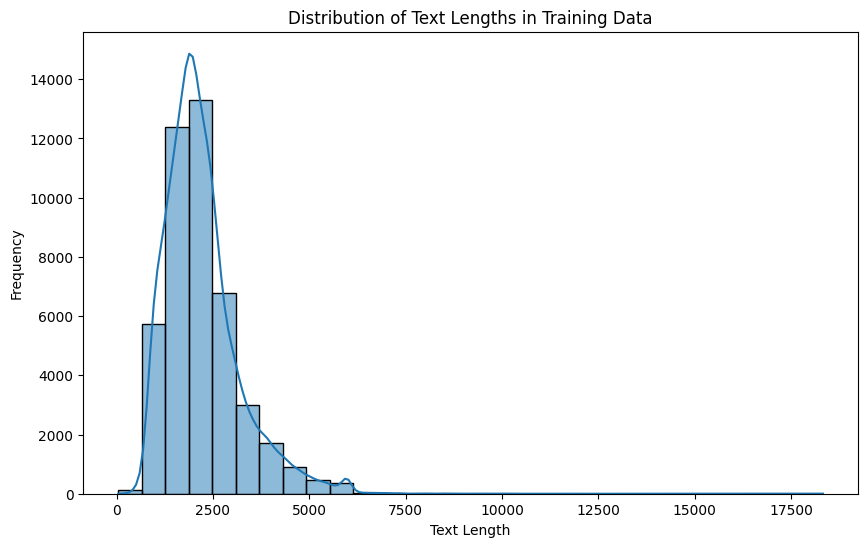

In [8]:
plot_text_length_distribution(train_essays_df, 'text', 'Distribution of Text Lengths in Training Data')



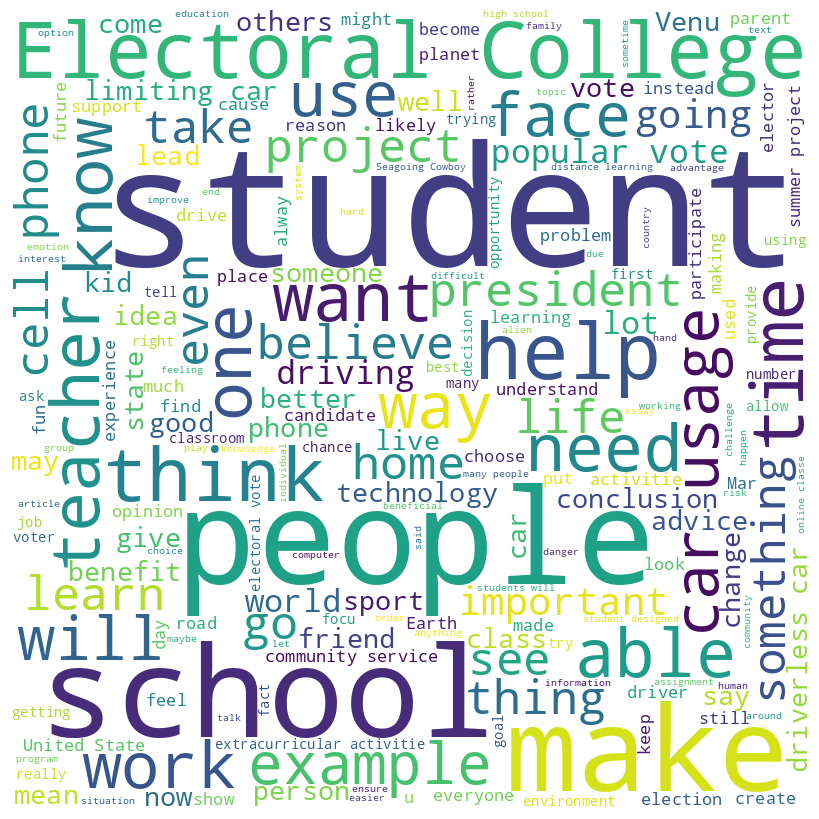

In [9]:
plot_word_cloud(train_essays_df, 'text')

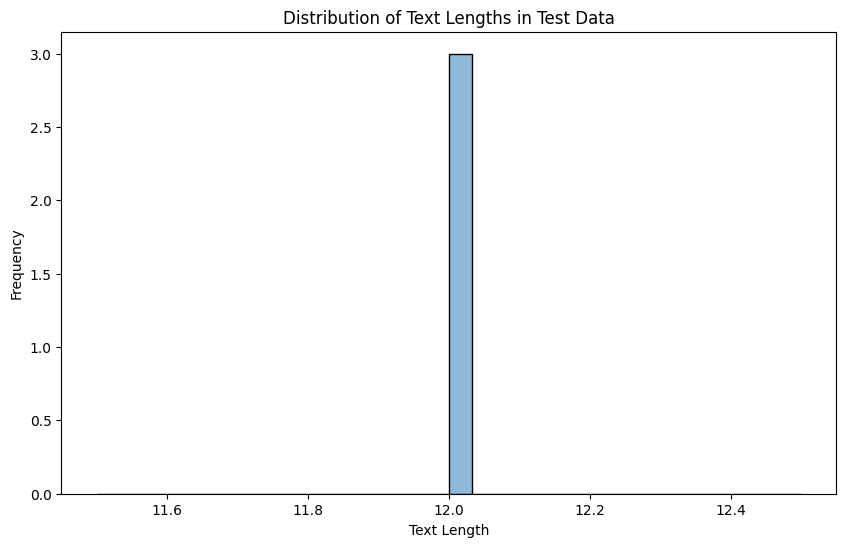

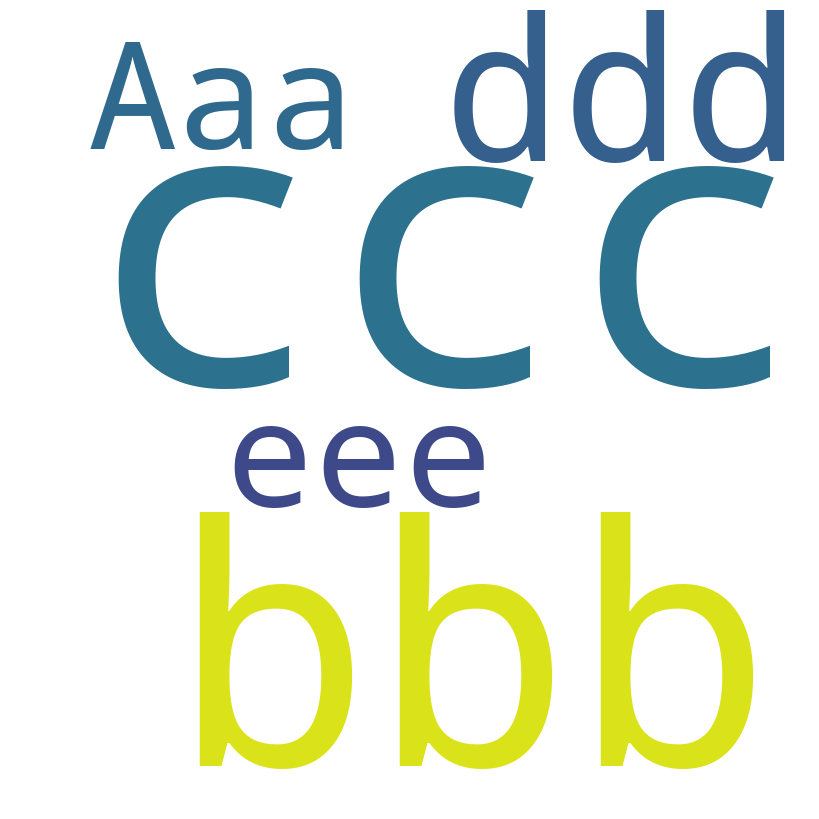

In [10]:
plot_text_length_distribution(test_essays_df, 'text', 'Distribution of Text Lengths in Test Data')
plot_word_cloud(test_essays_df, 'text')


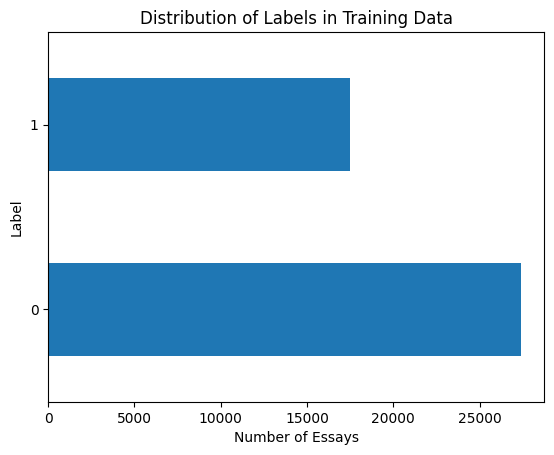

In [15]:
train_essays_df['label'].value_counts().plot(kind='barh')
plt.title('Distribution of Labels in Training Data')
plt.xlabel('Number of Essays')
plt.ylabel('Label')
plt.show()

In [16]:
tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))
tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()
tokenizer.normalizer = normalizers.Sequence([normalizers.NFD(), normalizers.Lowercase(),
                                             normalizers.StripAccents()])

trainer = trainers.BpeTrainer(vocab_size=30522, special_tokens=
                              ["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])

data_for_tokenizer_train = test_essays_df['text'].tolist()
tokenizer.train_from_iterator(data_for_tokenizer_train, trainer)

tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=tokenizer,
    unk_token="[UNK]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    pad_token="[PAD]",
    mask_token="[MASK]",
)

test_essays_df['text'] = test_essays_df['text'].apply(
    lambda x: tokenizer.tokenize(x, add_special_tokens=True))


train_essays_df['text'] = train_essays_df['text'].apply(
    lambda x: tokenizer.tokenize(x, add_special_tokens=True))

In [17]:
def dummy(text):
    return text

vectorizer = TfidfVectorizer(ngram_range=(3, 5), tokenizer=dummy, preprocessor=dummy,
                             sublinear_tf=True, token_pattern=None, lowercase=False,
                             )

vectorizer.fit(test_essays_df['text'])
vocab = vectorizer.vocabulary_
del vectorizer

vectorizer = TfidfVectorizer(ngram_range=(3, 5), tokenizer=dummy, preprocessor=dummy,
                             sublinear_tf=True, token_pattern=None, vocabulary=vocab, lowercase=False,
                             )

X_train = vectorizer.fit_transform(train_essays_df['text']).astype('float32')
X_test = vectorizer.transform(test_essays_df['text']).astype('float32')

del vectorizer
gc.collect()

10857

In [18]:
k = X_train.shape[1] // 100
selector = SelectKBest(chi2, k=k)
X_train_selected = selector.fit_transform(X_train, train_essays_df['label'])
X_val_selected = selector.transform(X_test)

# Splitting train data for validation
y = train_essays_df['label'].values
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_selected, y, test_size=0.2, random_state=42)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(


In [19]:
features = X_train_selected.shape[1]
# Simplified Model Architecture
model = Sequential()
model.add(tf.keras.Input(shape=(features,), sparse=True))
model.add(Dense(64, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
# Adjusted Class Weights
class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train_split)
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict[1] *= 0.8  # Slightly reduce the weight of the minority class

early_stopping = EarlyStopping(monitor='val_loss', patience=2)
history = model.fit(X_train_split, y_train_split, class_weight=class_weight_dict, validation_data=(X_val_split, y_val_split), batch_size=64, epochs=10, callbacks=[early_stopping], verbose=1)

Epoch 1/10
561/561 [==============================] - 6s 4ms/step - loss: 0.6200 - accuracy: 0.6078 - val_loss: 0.6773 - val_accuracy: 0.6108
Epoch 2/10
561/561 [==============================] - 2s 4ms/step - loss: 0.6183 - accuracy: 0.6099 - val_loss: 0.6747 - val_accuracy: 0.6108
Epoch 3/10
561/561 [==============================] - 2s 4ms/step - loss: 0.6183 - accuracy: 0.6099 - val_loss: 0.6748 - val_accuracy: 0.6108
Epoch 4/10
561/561 [==============================] - 2s 4ms/step - loss: 0.6183 - accuracy: 0.6099 - val_loss: 0.6742 - val_accuracy: 0.6108
Epoch 5/10
561/561 [==============================] - 2s 3ms/step - loss: 0.6183 - accuracy: 0.6099 - val_loss: 0.6743 - val_accuracy: 0.6108
Epoch 6/10
561/561 [==============================] - 2s 4ms/step - loss: 0.6183 - accuracy: 0.6099 - val_loss: 0.6746 - val_accuracy: 0.6108


In [21]:
val_predictions = model.predict(X_val_split)
val_predicted_labels = (val_predictions > 0.5).astype(int)

print(classification_report(y_val_split, val_predicted_labels))

281/281 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.61      1.00      0.76      5481
           1       0.00      0.00      0.00      3493

    accuracy                           0.61      8974
   macro avg       0.31      0.50      0.38      8974
weighted avg       0.37      0.61      0.46      8974



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
X_test_selected = selector.transform(X_test)
predictions = model.predict(X_test_selected)
test_essays_df['generated'] = predictions


1/1 [==============================] - 0s 20ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(


In [23]:
test_essays_df[["id", "generated"]].to_csv('submission.csv', index=False)

In [24]:
predictions

array([[0.44408634],
       [0.44408634],
       [0.44408634]], dtype=float32)

In [32]:
train_essays_df['text'] = train_essays_df['text'].astype(str).str.replace('\n', ' ')
test_essays_df['text'] = test_essays_df['text'].astype(str).str.replace('\n', ' ')


In [35]:
# Initialize BERT tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize text
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []

    for text in texts:
        if text is None or not isinstance(text, str):
            continue  # Skip non-string values

        text = tokenizer.tokenize(text)

        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)

        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len

        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)

    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)


# Encode training and test data
train_input = bert_encode(train_essays_df.text.values, tokenizer, max_len=160)
test_input = bert_encode(test_essays_df.text.values, tokenizer, max_len=160)
train_labels = train_essays_df.label.values


In [37]:
from transformers import TFBertModel
# Load BERT model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Build the model
input_word_ids = Input(shape=(160,), dtype=tf.int32, name="input_word_ids")
input_mask = Input(shape=(160,), dtype=tf.int32, name="input_mask")
segment_ids = Input(shape=(160,), dtype=tf.int32, name="segment_ids")

# Properly extract the pooled_output from BERT model
bert_output = bert_model([input_word_ids, input_mask, segment_ids])
pooled_output = bert_output[1]  # Use the pooled output for classification

out = Dense(1, activation='sigmoid')(pooled_output)

model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
model.compile(tf.keras.optimizers.Adam(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
train_history = model.fit(
    train_input, train_labels,
    epochs=3,
    batch_size=10,
    validation_split=0.2
)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/3
3590/3590 [==============================] - 1386s 375ms/step - loss: 0.6130 - accuracy: 0.7153 - val_loss: 1.5147 - val_accuracy: 0.1532
Epoch 2/3
3590/3590 [==============================] - 1343s 374ms/step - loss: 0.6139 - accuracy: 0.7145 - val_loss: 1.2378 - val_accuracy: 0.1532
Epoch 3/3
3590/3590 [==============================] - 1343s 374ms/step - loss: 0.6092 - accuracy: 0.7174 - val_loss: 1.1857 - val_accuracy: 0.1532


In [40]:
# Extract BERT embeddings
train_embeddings = model.predict(train_input)

# Split data for ensemble training
X_train, X_val, y_train, y_val = train_test_split(train_embeddings, train_labels, test_size=0.2, random_state=42)

# Apply SMOTE for handling class imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
X_val_smote, y_val_smote = smote.fit_resample(X_val, y_val)

1403/1403 [==============================] - 461s 329ms/step


In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Build a simple neural network
nn_model = Sequential([
    Dense(128, activation='relu', input_dim=train_embeddings.shape[1]),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the neural network
nn_history = nn_model.fit(
    X_train_smote, y_train_smote,
    epochs=10,
    batch_size=32,
    validation_data=(X_val_smote, y_val_smote)
)

# Evaluate the model and print classification report
y_val_pred = nn_model.predict(X_val)
print(classification_report(y_val, y_val_pred.round()))

# Predict on test data
test_embeddings = model.predict(test_input)
X_test_selected = test_embeddings

predictions = nn_model.predict(X_test_selected)

# Create submission file
test_essays_df['generated'] = predictions
test_essays_df[["id", "generated"]].to_csv('submission.csv', index=False)

Epoch 1/10
1369/1369 [==============================] - 6s 4ms/step - loss: 0.6935 - accuracy: 0.5021 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/10
1369/1369 [==============================] - 5s 3ms/step - loss: 0.6933 - accuracy: 0.4973 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/10
1369/1369 [==============================] - 5s 3ms/step - loss: 0.6933 - accuracy: 0.5001 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/10
1369/1369 [==============================] - 5s 3ms/step - loss: 0.6932 - accuracy: 0.4970 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/10
1369/1369 [==============================] - 5s 3ms/step - loss: 0.6932 - accuracy: 0.4984 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/10
1369/1369 [==============================] - 5s 3ms/step - loss: 0.6932 - accuracy: 0.4958 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/10
1369/1369 [==============================] - 5s 3ms/step - loss: 0.6932 - accuracy: 0.4939 - val_loss: 0.6932 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 0s 18ms/step


In [43]:
# Encode training and test data
train_input = bert_encode(train_essays_df.text.values, tokenizer, max_len=160)
test_input = bert_encode(test_essays_df.text.values, tokenizer, max_len=160)
train_labels = train_essays_df.label.values

# Load BERT model and set it to be trainable
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
bert_model.trainable = True

# Build the model
input_word_ids = Input(shape=(160,), dtype=tf.int32, name="input_word_ids")
input_mask = Input(shape=(160,), dtype=tf.int32, name="input_mask")
segment_ids = Input(shape=(160,), dtype=tf.int32, name="segment_ids")

bert_output = bert_model([input_word_ids, input_mask, segment_ids])
pooled_output = bert_output[1]

out = Dense(1, activation='sigmoid')(pooled_output)
model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)

# Compile the model
model.compile(tf.keras.optimizers.Adam(learning_rate=2e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model with early stopping
train_history = model.fit(
    train_input, train_labels,
    epochs=5,
    batch_size=10,
    validation_split=0.2,
    callbacks=[early_stopping]
)

# Extract BERT embeddings for further NN model
train_embeddings = model.predict(train_input)

# Split data for ensemble training
X_train, X_val, y_train, y_val = train_test_split(train_embeddings, train_labels, test_size=0.2, random_state=42)

# Apply SMOTE for handling class imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Build a simple neural network
nn_model = Sequential([
    Dense(128, activation='relu', input_dim=train_embeddings.shape[1]),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the neural network
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the neural network
nn_history = nn_model.fit(
    X_train_smote, y_train_smote,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)

# Evaluate the model and print classification report
y_val_pred = nn_model.predict(X_val)
print(classification_report(y_val, y_val_pred.round()))

# Predict on test data
test_embeddings = model.predict(test_input)
predictions = nn_model.predict(test_embeddings)

# Create submission file
test_essays_df['generated'] = predictions
test_essays_df[["id", "generated"]].to_csv('submission.csv', index=False)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/5
3590/3590 [==============================] - 1391s 376ms/step - loss: 0.5906 - accuracy: 0.7239 - val_loss: 1.2912 - val_accuracy: 0.1532
Epoch 2/5
3590/3590 [==============================] - 1349s 376ms/step - loss: 0.5923 - accuracy: 0.7241 - val_loss: 1.2454 - val_accuracy: 0.1532
Epoch 3/5
3590/3590 [==============================] - 1350s 376ms/step - loss: 0.5912 - accuracy: 0.7242 - val_loss: 1.1932 - val_accuracy: 0.1532
Epoch 4/5
3590/3590 [==============================] - 1350s 376ms/step - loss: 0.5904 - accuracy: 0.7242 - val_loss: 1.1652 - val_accuracy: 0.1532
Epoch 5/5
1403/1403 [==============================] - 468s 332ms/step
Epoch 1/10
1369/1369 [==============================] - 6s 3ms/step - loss: 0.6934 - accuracy: 0.5037 - val_loss: 0.6900 - val_accuracy: 0.6108
Epoch 2/10
1369/1369 [==============================] - 5s 3ms/step - loss: 0.6933 - accuracy: 0.4997 - val_loss: 0.6946 - val_accuracy: 0.3892
Epoch 3/10
1369/1369 [===========================

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 0s 17ms/step
